Notebook 2 of 2

# A) Data Integration

In [ ]:
# import dataset

from google.colab import files
uploaded=files.upload()

Saving Wellbeing_and_lifestyle_data_Kaggle.csv to Wellbeing_and_lifestyle_data_Kaggle.csv


In [ ]:
# Read csv file
import io
df_orig = pd.read_csv(io.BytesIO(uploaded['Wellbeing_and_lifestyle_data_Kaggle.csv']))

# B) Final preprocessing pipeline 


In [ ]:
# preprocessing pipeline code

# imports
import numpy as np
import pandas as pd
import imblearn
from pprint import pprint
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Settings for figures
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
sns.set_context("notebook")
sns.set_style("whitegrid")

# Make this notebook's stable across runs
random_state=42

###################### Define custom functions ######################

# Clean target variable
def clean_target(col):
    remove_typo = col.astype(str).apply(lambda x: x[0]) # get first character to fix typo at line 10005
    numeric = remove_typo.astype(np.int64)
    return(numeric)

# need to convert results of the basic cleaning pipeline back to a dataframe after basic cleaning done
def reformat_cleaned_df(data):
  df = pd.DataFrame(data)
  df.columns = col_names
  return(df)


################## Step 0: Basic cleaning ################## 

# drop duplicate rows
df_unique = df_orig.drop_duplicates()

# drop unnecessary columns
df_unique = df_unique.drop(["Timestamp", "WORK_LIFE_BALANCE_SCORE"], axis = 1) 

# convert dtype "object" to "category" (required for compatibility with automl)
df_unique[df_unique.select_dtypes(['object']).columns] = df_unique.select_dtypes(['object']).apply(lambda x: x.astype('category'))


################## Step 1: Define X and y ################## 

X = df_unique.drop(["DAILY_STRESS"], axis = 1)
y = df_unique[["DAILY_STRESS"]]


################## Step 2: Target variable cleaning ################## 

y["DAILY_STRESS"] = clean_target(y["DAILY_STRESS"])


################## Step 3: Train/test split ################## 

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), test_size = 0.2, stratify = y, random_state = random_state)


################## Step 4: Basic cleaning ################## 

# (i) save X feature column names, as these will be removed by cleaning steps
col_names = X.columns

# (ii) missing values: for forward compatibility, include a SimpleImputer(strategy = "most_frequent")
imputer = SimpleImputer(strategy = "most_frequent") 


################## Step 5: Assemble ColumnTransformer ################## 

# (i) gender binary encoding (this produces 0 and 1 so don't need minmax scaling)
gender = ["GENDER"]
gender_transformer = OneHotEncoder(drop="first", sparse=False)

# (ii) age ordinal encoding by age group (in order from lowest to highest age group) & scaling
age = ["AGE"]
age_transformer = Pipeline(steps = [
    ("encode", OrdinalEncoder(categories=[['Less than 20', '21 to 35', '36 to 50', '51 or more']], dtype=np.int64)),
    ("scale", MinMaxScaler()) 
    ])

# (iii) scaling

# scale all X features except the vars already dealt with above
to_scale = X.drop(columns=["GENDER", "AGE"], axis = 1).columns 
scaler = MinMaxScaler() 

# (iv) assemble the column transformer
column_transformers = ColumnTransformer(transformers=[
                                                      ("age", age_transformer, age),
                                                      ("gender", gender_transformer, gender),
                                                      ("others", scaler, to_scale)
                                                      ], remainder="drop")

################## Step 6: Assemble entire pipeline ################## 

preprocessor = Pipeline(steps=[
                               ("impute", imputer),
                               ("reformat", FunctionTransformer(reformat_cleaned_df)),
                               ("col_transform", column_transformers)
                               ])


In [ ]:
# dimensions of train/test sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (12392, 21)
X_test shape: (3098, 21)
y_train shape: (12392,)
y_test shape: (3098,)


# C) Classification Models

In [ ]:
#required imports
import numpy as np
from numpy import mean, std
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
%matplotlib inline
import time
# Make this notebook's stable across runs
random_state=42

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import randint
from sklearn.model_selection import learning_curve


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline


from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold


## Define class weights

In [ ]:
from sklearn.utils.class_weight import compute_sample_weight

class_weight = {0:.05, 1:.10, 2:.10, 3:.15, 4:.25, 5:.35}

# Define a dictionnary for the weight for each class {class:weight}
weight_dict = class_weight

# Convert the class_weight dict into an array (n_samples, )
weight_array_train = compute_sample_weight(class_weight=class_weight, y=y_train)
weight_array_test = compute_sample_weight(class_weight=class_weight, y=y_test)

## Define metrics



In [ ]:
from imblearn.metrics import geometric_mean_score as gmean
from sklearn.metrics import make_scorer
from imblearn.metrics import sensitivity_score

# Define metrics
metrics = make_scorer(sensitivity_score, average='weighted', sample_weight=weight_array_train)


## Define custom functions

## Define models to tune

In [ ]:
#For KNeighbors
knn = Pipeline([("preprocessor", preprocessor),
                ("model", KNeighborsClassifier())
                ])

#For Random Forest
rf = Pipeline([("preprocessor", preprocessor),
               ("model", RandomForestClassifier())
               ])

#Extra Trees - This is more flexible than Adaboost (other option)
e_t = Pipeline([("preprocessor", preprocessor),
                ("model", ExtraTreesClassifier())
                ])

#For MLP
mlp = Pipeline([("preprocessor", preprocessor),
                ("model", MLPClassifier())
                ])

#For QDA
qda = Pipeline([("preprocessor", preprocessor),
                ("model", QuadraticDiscriminantAnalysis())
                ])

#For PassiveAggressive Classifier
pa = Pipeline([("preprocessor", preprocessor),
               ("model", PassiveAggressiveClassifier())
               ])

## Fine-tuning

### KNN

In [ ]:
#n_neighbours tuning for knn

n_neighbors = list(range(5,101,5))


#create random grid

knn_random_grid = {'model__n_neighbors': n_neighbors}


knn_tuned = RandomizedSearchCV(knn, knn_random_grid, scoring=metrics, n_iter=20, cv=3, verbose=2, random_state=42)

start = time.process_time()
# Fit the random search model
knn_tuned.fit(X_train, y_train)

#save best model

knn_best = knn_tuned.best_estimator_
knn_params = knn_tuned.best_params_

print(f"\nIt took K-Nearest Neighbor Classifier {round(time.process_time() - start,2)} sec to run")
print(f"\nBest K-Nearest Neighbor Classifier Parameters: {knn_tuned.best_params_}")
# print(f"\nBest K-Nearest Neighbor Classifier score is {knn_tuned.best_score_}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ...............................model__n_neighbors=5; total time=   0.9s
[CV] END ...............................model__n_neighbors=5; total time=   0.8s
[CV] END ...............................model__n_neighbors=5; total time=   0.9s
[CV] END ..............................model__n_neighbors=10; total time=   0.9s
[CV] END ..............................model__n_neighbors=10; total time=   0.8s
[CV] END ..............................model__n_neighbors=10; total time=   0.9s
[CV] END ..............................model__n_neighbors=15; total time=   0.9s
[CV] END ..............................model__n_neighbors=15; total time=   0.8s
[CV] END ..............................model__n_neighbors=15; total time=   0.9s
[CV] END ..............................model__n_neighbors=20; total time=   0.9s
[CV] END ..............................model__n_neighbors=20; total time=   0.8s
[CV] END ..............................model__n_

### PA

In [ ]:
#C tuning for PA
C = list(np.arange(0.0, 2.0, 0.05))

pa_random_grid = {'model__C': C}

pa_tuned = RandomizedSearchCV(pa, pa_random_grid, scoring=metrics, n_iter=20, cv=3, verbose=2, random_state=42)

start = time.process_time()

# Fit the random search model
pa_tuned.fit(X_train, y_train)

#save best model
pa_best = pa_tuned.best_estimator_
pa_params = pa_tuned.best_params_

print(f"\nIt took Passive Aggressive Classifier {round(time.process_time() - start,2)} sec to run")
print(f"\nBest Passive Aggressive Classifier Parameters: {pa_tuned.best_params_}")
# print(f"\nBest Passive Aggressive Classifier score is {pa_tuned.best_score_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ........................model__C=0.9500000000000001; total time=   0.2s
[CV] END ........................model__C=0.9500000000000001; total time=   0.2s
[CV] END ........................model__C=0.9500000000000001; total time=   0.2s
[CV] END .......................................model__C=0.8; total time=   0.2s
[CV] END .......................................model__C=0.8; total time=   0.2s
[CV] END .......................................model__C=0.8; total time=   0.2s
[CV] END ......................................model__C=0.75; total time=   0.2s
[CV] END ......................................model__C=0.75; total time=   0.2s
[CV] END ......................................model__C=0.75; total time=   0.2s
[CV] END .......................................model__C=1.3; total time=   0.2s
[CV] END .......................................model__C=1.3; total time=   0.2s
[CV] END .......................................

### ET

In [ ]:
#Hyperparameter tuning for E_T:
n_estimators = [int(n) for n in np.linspace(start=25, stop=100, num=15)]
# Minimum number of samples required to split a node
min_samples_split = randint(1,10)
# Minimum number of samples required at each leaf node
min_samples_leaf = randint(1,5)
# Method of selecting samples for training each tree
bootstrap = [True,False]


# Create the random grid
e_t_random_grid = {'model__n_estimators': n_estimators,
                   'model__min_samples_split': min_samples_split,
                   'model__min_samples_leaf': min_samples_leaf,
                   'model__bootstrap': bootstrap}

# search across 50 different combinations, and use all available cores
e_t_tuned = RandomizedSearchCV(e_t, e_t_random_grid, scoring=metrics, n_iter=20, cv=3, verbose=2, random_state=42)

start = time.process_time()

# Fit the random search model
e_t_tuned.fit(X_train, y_train)

#save best model
e_t_best = e_t_tuned.best_estimator_
e_t_params = e_t_tuned.best_params_

print(f"\nIt took Tuned Extra Trees Classifier {round(time.process_time() - start,2)} sec to run")
print(f"\nBest Tuned Extra Trees Classifier Parameters: {e_t_random.best_params_}")
# print(f"\nBest Tuned Extra Trees Classifier score is {e_t_random.best_score_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END model__bootstrap=True, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=89; total time=   0.8s
[CV] END model__bootstrap=True, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=89; total time=   0.8s
[CV] END model__bootstrap=True, model__min_samples_leaf=4, model__min_samples_split=8, model__n_estimators=89; total time=   0.8s
[CV] END model__bootstrap=True, model__min_samples_leaf=3, model__min_samples_split=3, model__n_estimators=57; total time=   0.6s
[CV] END model__bootstrap=True, model__min_samples_leaf=3, model__min_samples_split=3, model__n_estimators=57; total time=   0.6s
[CV] END model__bootstrap=True, model__min_samples_leaf=3, model__min_samples_split=3, model__n_estimators=57; total time=   0.6s
[CV] END model__bootstrap=True, model__min_samples_leaf=3, model__min_samples_split=8, model__n_estimators=46; total time=   0.5s
[CV] END model__bootstrap=Tru

Comment on Best model parameters

### MLP

In [ ]:
#Hyperparameter tuning for MLP:
activation = ['tanh','relu']

early_stopping = [False, 'train']

hidden_layer_sizes = randint(2,100)

n_iter_no_change = randint(1,10)

alpha = uniform(loc=0.1, scale=1)

mlp_random_grd = {'model__n_iter_no_change': n_iter_no_change,
                  'model__early_stopping': early_stopping,
                  'model__hidden_layer_sizes': hidden_layer_sizes,
                  'model__alpha': alpha,
                  'model__activation': activation}

# search across different combinations, and use all available cores
mlp_tuned = RandomizedSearchCV(mlp, mlp_random_grd, scoring=metrics, n_iter=30, cv=3, verbose=2, random_state=42)

start = time.process_time()

# Fit the random search model
mlp_tuned.fit(X_train, y_train)

#save best model
mlp_best = mlp_tuned.best_estimator_
mlp_params = mlp_tuned.best_params_
#check best n_estimators value
print(f"\nIt took Multi-layer Perceptron classifier {round(time.process_time() - start,2)} sec to run") # 4 min
print(f"\nBest Multi-layer Perceptron classifier Parameters: {mlp_tuned.best_params_}")
# print(f"\nBest Multi-layer Perceptron classifier score is {mlp_tuned.best_score_}")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END model__activation=tanh, model__alpha=0.8965429868602328, model__early_stopping=False, model__hidden_layer_sizes=73, model__n_iter_no_change=5; total time=   5.9s
[CV] END model__activation=tanh, model__alpha=0.8965429868602328, model__early_stopping=False, model__hidden_layer_sizes=73, model__n_iter_no_change=5; total time=   5.4s
[CV] END model__activation=tanh, model__alpha=0.8965429868602328, model__early_stopping=False, model__hidden_layer_sizes=73, model__n_iter_no_change=5; total time=   4.6s
[CV] END model__activation=tanh, model__alpha=0.5458327528535911, model__early_stopping=False, model__hidden_layer_sizes=76, model__n_iter_no_change=8; total time=   7.5s
[CV] END model__activation=tanh, model__alpha=0.5458327528535911, model__early_stopping=False, model__hidden_layer_sizes=76, model__n_iter_no_change=8; total time=   7.6s
[CV] END model__activation=tanh, model__alpha=0.5458327528535911, model__early_stopp

### QDA

In [ ]:
#Hyperparameter tuning for QDA:
from scipy.stats import uniform

reg_param = uniform(loc=0.001, scale=0.5)

qda_random_grd = {'model__reg_param': reg_param}


# search across 10 different combinations, and use all available cores
qda_tuned = RandomizedSearchCV(qda, qda_random_grd, scoring=metrics, n_iter=20, cv=3, verbose=2, random_state=42)

start = time.process_time()

# Fit the random search model
qda_tuned.fit(X_train, y_train)

#save best model
qda_best = qda_tuned.best_estimator_
qda_params = qda_tuned.best_params_

#check best n_estimators value
print(f"\nIt took Quadratic Discriminant Analysis {round(time.process_time() - start,2)} sec to run")
print(f"\nBest Quadratic Discriminant Analysis Parameters: {qda_tuned.best_params_}")
# print(f"\nBest Quadratic Discriminant Analysis score is {qda_tuned.best_score_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ...............model__reg_param=0.18827005942368125; total time=   0.1s
[CV] END ...............model__reg_param=0.18827005942368125; total time=   0.2s
[CV] END ...............model__reg_param=0.18827005942368125; total time=   0.2s
[CV] END ................model__reg_param=0.4763571532049581; total time=   0.2s
[CV] END ................model__reg_param=0.4763571532049581; total time=   0.2s
[CV] END ................model__reg_param=0.4763571532049581; total time=   0.2s
[CV] END ...............model__reg_param=0.36699697090570255; total time=   0.2s
[CV] END ...............model__reg_param=0.36699697090570255; total time=   0.2s
[CV] END ...............model__reg_param=0.36699697090570255; total time=   0.2s
[CV] END ................model__reg_param=0.3003292420985183; total time=   0.2s
[CV] END ................model__reg_param=0.3003292420985183; total time=   0.2s
[CV] END ................model__reg_param=0.3003

### RFC

In [ ]:
#Hyperparameter tuning for RF:

n_estimators = [int(n) for n in np.linspace(start=100, stop=1000, num=10)]

min_samples_split = randint(2,10)

min_samples_leaf = randint(1,10)

bootstrap = [True,False]

# Create the random grid
rf_random_grid = {'model__n_estimators': n_estimators,
                  'model__min_samples_split': min_samples_split,
                  'model__min_samples_leaf': min_samples_leaf,
                  'model__bootstrap': bootstrap}

# search across 50 different combinations, and use all available cores
rf_tuned = RandomizedSearchCV(rf, rf_random_grid, scoring=metrics, n_iter=20, cv=3, verbose=2, random_state=42)

start = time.process_time()

# Fit the random search model
rf_tuned.fit(X_train, y_train)

#save best model
rf_best = rf_tuned.best_estimator_
rf_params = rf_tuned.best_params_
#check best n_estimators value
print(f"\nIt took Random Forest Analysis {round(time.process_time() - start,2)} sec to run") # 9 min
print(f"\nBest Random Forest Classifier Parameters: {rf_tuned.best_params_}")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END model__bootstrap=True, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=800; total time=   9.6s
[CV] END model__bootstrap=True, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=800; total time=   9.7s
[CV] END model__bootstrap=True, model__min_samples_leaf=4, model__min_samples_split=6, model__n_estimators=800; total time=   9.7s
[CV] END model__bootstrap=True, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=1000; total time=  11.4s
[CV] END model__bootstrap=True, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=1000; total time=  11.4s
[CV] END model__bootstrap=True, model__min_samples_leaf=5, model__min_samples_split=8, model__n_estimators=1000; total time=  11.4s
[CV] END model__bootstrap=True, model__min_samples_leaf=7, model__min_samples_split=4, model__n_estimators=800; total time=   8.5s
[CV] END model__boo

In [ ]:
def get_best_models():
	best_models = dict()
	best_models['Best Random Forest'] = rf_best
	best_models['Best Extra Trees'] = e_t_best
	best_models['Best MLP'] = mlp_best
	best_models['Best QDA'] = qda_best
	best_models['Best PA'] = pa_best
	best_models['Best KNN'] = knn_best
	return best_models 

#-------------------- RECALL -------------------------------------

# evaluate a given model using cross-validation
def evaluate_model_recall(model, X_train, y_train): # specified X_train because of the weight_array_train, so cannot use the same function for X_test
	# Compute predictions
	yhat_cv = cross_val_predict(model, X_train, y_train, cv=10)
	#---------Recall-----------
	recall = sensitivity_score(y_train, yhat_cv, average='weighted', sample_weight=weight_array_train)*100
	# scores = cross_val_score(model, X_train, y_train, scoring=metrics, cv=cv) # because cross_val_score doesn't take class_weights so can't use here
	return recall


#------------------ G-Mean ----------------------------------------

def evaluate_model_gmean(model, X_train, y_train):
	# Compute predictions
	yhat_cv = cross_val_predict(model, X_train, y_train, cv=10)
  #---------G-Mean-----------
	gmeam = gmean(y_train, yhat_cv, average='weighted', sample_weight=weight_array_train)
	scores = cross_val_score(model, X_train, y_train, scoring=metrics, cv=10)
	return gmean


### Ranking individual models

In [ ]:
# get the models to evaluate
best_models = get_best_models()

# evaluate the models and store results
best_results, best_names = list(), list()
for name, model in best_models.items():
	best_recall = evaluate_model_recall(model, X_train, y_train)
	best_results.append(best_recall)
	best_names.append(name)
	print(f'Recall (class weighted, cv) for {name} model, : {round(mean(best_recall),1)}%')
 
## plot model performance for comparison
plt.boxplot(best_results_rec, labels=best_names_rec, showmeans=True)
plt.show()

Recall (class weighted, cv) for Best Random Forest model, : 31.7%
Recall (class weighted, cv) for Best Extra Trees model, : 30.6%
Recall (class weighted, cv) for Best MLP model, : 30.0%
Recall (class weighted, cv) for Best QDA model, : 25.5%
Recall (class weighted, cv) for Best PA model, : 20.7%
Recall (class weighted, cv) for Best KNN model, : 22.7%


### Stacking


In [ ]:
# Define the order based on primary metrics - Recall weighted by class


#1st Random Forest Classifier
rf_best
rf_params

# 2nd Extra Trees
e_t_best
e_t_params

# 3rd MLP
mlp_best
mlp_params

# 4th QDA
qda_best
qda_params

# 5th Knn
knn_best
knn_params

# 6th PA
pa_best
pa_params

{'model__C': 0.9500000000000001}

#### Top 5

In [ ]:
from sklearn import set_config

# Settings to display stacking
set_config(display="diagram")

def get_5best_stacking():
	# define the base models
	model_grp_best = list()
	model_grp_best.append(('Best Random Forest', rf_best))
	model_grp_best.append(('Best Extra Trees', e_t_best))
	model_grp_best.append(('Best MLP', mlp_best))
	model_grp_best.append(('Best QDA', qda_best)) 
	model_grp_best.append(('Best KNN', knn_best))

	# define meta learner model
	final = ExtraTreesClassifier()

	# define the stacking ensemble
	model_best = StackingClassifier(estimators=model_grp_best, final_estimator=final, cv=5)
	# return model 
	return model_best 


stacking_5models = get_5best_stacking().fit(X_train, y_train)

stacking_5models 

StackingClassifier(cv=5,
                   estimators=[('Best Random Forest',
                                Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('impute',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('reformat',
                                                                  FunctionTransformer(func=<function reformat_cleaned_df at 0x7ff5ab7c63b0>)),
                                                                 ('col_transform',
                                                                  ColumnTransformer(transformers=[('age',
                                                                                                   Pipeline(steps=[('encode',
                                                                                                                    OrdinalEncoder(categories=[[...
                                                                                                   Index(['FRUITS_VEGGIES', 'PLACES_VISITED', 'CORE_CIRCLE', 'SUPPORTING_OTHERS',
       'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION', 'BMI_RANGE',
       'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS',
       'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME',
       'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION'],
      dtype='object'))]))])),
                                                ('model',
                                                 KNeighborsClassifier())]))],
                   final_estimator=ExtraTreesClassifier())

#### Top 4

In [ ]:
#Get 4 stacking 

#Settings to display stacking
set_config(display="diagram")

def get_4best_stacking():
	# define the base models
	model_grp_best = list()
	model_grp_best.append(('Best Random Forest', rf_best))
	model_grp_best.append(('Best Extra Trees', e_t_best))
	model_grp_best.append(('Best MLP', mlp_best))
	model_grp_best.append(('Best QDA', qda_best))


	# define meta learner model
	final = ExtraTreesClassifier()

	# define the stacking ensemble
	model_best = StackingClassifier(estimators=model_grp_best, final_estimator=final, cv=5)
	# return model 
	return model_best 

stacking_4models = get_4best_stacking().fit(X_train, y_train)

stacking_4models 

StackingClassifier(cv=5,
                   estimators=[('Best Random Forest',
                                Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('impute',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('reformat',
                                                                  FunctionTransformer(func=<function reformat_cleaned_df at 0x7ff5ab7c63b0>)),
                                                                 ('col_transform',
                                                                  ColumnTransformer(transformers=[('age',
                                                                                                   Pipeline(steps=[('encode',
                                                                                                                    OrdinalEncoder(categories=[[...
       'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION', 'BMI_RANGE',
       'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS',
       'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME',
       'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION'],
      dtype='object'))]))])),
                                                ('model',
                                                 QuadraticDiscriminantAnalysis(reg_param=0.18827005942368125))]))],
                   final_estimator=ExtraTreesClassifier())

#### Top 3

In [ ]:
#Get 3 stacking 

#Settings to display stacking
set_config(display="diagram")

def get_3best_stacking():
	# define the base models
	model_grp_best = list()
	model_grp_best.append(('Best Random Forest', rf_best))
	model_grp_best.append(('Best Extra Trees', e_t_best))
	model_grp_best.append(('Best MLP', mlp_best))


	# define meta learner model
	final = ExtraTreesClassifier()

	# define the stacking ensemble
	model_best = StackingClassifier(estimators=model_grp_best, final_estimator=final, cv=5)
	# return model 
	return model_best 

stacking_3models = get_3best_stacking().fit(X_train, y_train)

stacking_3models


StackingClassifier(cv=5,
                   estimators=[('Best Random Forest',
                                Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('impute',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('reformat',
                                                                  FunctionTransformer(func=<function reformat_cleaned_df at 0x7ff5ab7c63b0>)),
                                                                 ('col_transform',
                                                                  ColumnTransformer(transformers=[('age',
                                                                                                   Pipeline(steps=[('encode',
                                                                                                                    OrdinalEncoder(categories=[[...
       'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS',
       'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME',
       'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION'],
      dtype='object'))]))])),
                                                ('model',
                                                 MLPClassifier(activation='tanh',
                                                               alpha=0.8965429868602328,
                                                               hidden_layer_sizes=73,
                                                               n_iter_no_change=5))]))],
                   final_estimator=ExtraTreesClassifier())

#### Top 2

In [ ]:
#Get 2 stacking 

#Settings to display stacking
set_config(display="diagram")

def get_2best_stacking():
	# define the base models
	model_grp_best = list()
	model_grp_best.append(('Best Random Forest', rf_best))
	model_grp_best.append(('Best Extra Trees', e_t_best))


	# define meta learner model
	final = ExtraTreesClassifier()

	# define the stacking ensemble
	model_best = StackingClassifier(estimators=model_grp_best, final_estimator=final, cv=5)
	# return model 
	return model_best 

stacking_2models = get_2best_stacking().fit(X_train, y_train)

stacking_2models

StackingClassifier(cv=5,
                   estimators=[('Best Random Forest',
                                Pipeline(steps=[('preprocessor',
                                                 Pipeline(steps=[('impute',
                                                                  SimpleImputer(strategy='most_frequent')),
                                                                 ('reformat',
                                                                  FunctionTransformer(func=<function reformat_cleaned_df at 0x7ff5ab7c63b0>)),
                                                                 ('col_transform',
                                                                  ColumnTransformer(transformers=[('age',
                                                                                                   Pipeline(steps=[('encode',
                                                                                                                    OrdinalEncoder(categories=[[...
       'SOCIAL_NETWORK', 'ACHIEVEMENT', 'DONATION', 'BMI_RANGE',
       'TODO_COMPLETED', 'FLOW', 'DAILY_STEPS', 'LIVE_VISION', 'SLEEP_HOURS',
       'LOST_VACATION', 'DAILY_SHOUTING', 'SUFFICIENT_INCOME',
       'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'WEEKLY_MEDITATION'],
      dtype='object'))]))])),
                                                ('model',
                                                 ExtraTreesClassifier(bootstrap=True,
                                                                      min_samples_leaf=4,
                                                                      min_samples_split=8,
                                                                      n_estimators=89))]))],
                   final_estimator=ExtraTreesClassifier())

#### Ranking stacked models

## Performance Metrics - All


### Results Summary

In [ ]:
# List of models to evaluate
def get_models():
    models = {}
    models['Stacking5'] = stacking_5models
    models['Stacking4'] = stacking_4models
    models['Stacking3'] = stacking_3models
    models['Stacking2'] = stacking_2models
    models['RF'] = rf_best
    models['ET'] = e_t_best
    models['MLP'] = mlp_best
    models['QDA'] = qda_best
    models['KNN'] = knn_best
    return models

# Models to evaluate
models = get_models()

# Evaluate models and store results
results = []
names = []

for name, model in models.items():
    print('Still working...')
    metrics = {'model': name}
    
    #---------Predictions-------------------
    yhat_cv = cross_val_predict(model, X_train, y_train, cv=3, method='predict', n_jobs=-1)
    yhat_train = model.predict(X_train)
    
    #---------Cross-validation------------------
    metrics['Recall (class weighted, cv)'] = sensitivity_score(y_train, yhat_cv, average='weighted', sample_weight=weight_array_train)*100
    metrics['G-Mean (class weighted, cv)'] = gmean(y_train, yhat_cv, average='weighted', sample_weight=weight_array_train)

    #-----------Training set------------------
    metrics['Recall (class weighted, train)'] = sensitivity_score(y_train, yhat_train, average='weighted', sample_weight=weight_array_train)*100
    metrics['G-Mean (class weighted, train)'] = gmean(y_train, yhat_train, average='weighted', sample_weight=weight_array_train)
    
    # Append results and names
    results.append(metrics)
    names.append(name)

# Create DF_results           # 12 min
df_results = pd.DataFrame(results).set_index('model').T
df_results.style.highlight_min(color='red', axis=1).highlight_max(color='green', axis=1)


Still working...
Still working...
Still working...
Still working...
Still working...
Still working...
Still working...
Still working...
Still working...


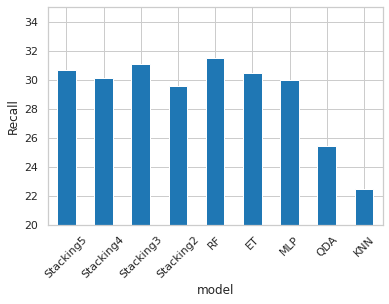

In [ ]:
# Plot all models except baseline

df_results.iloc[0,:].plot(kind='bar', rot=45)
plt.ylim(20,35)
plt.ylabel('Recall');

## Final Model

Based on the results summary table, it is clear that the majority of models/stacking ensemble are overfitting the training set. The only 2 models that seems to have good generalization capacities are MLP and QDA. Unfortunately, these 2 models have lower Recall scores than the other models but not much lower especially for MLP (difference of 1.5% from the highest score with RF). As a result, the final model is MLP which shows the highest score among the 2 models remaining to choose from.

### Confusion Matrix

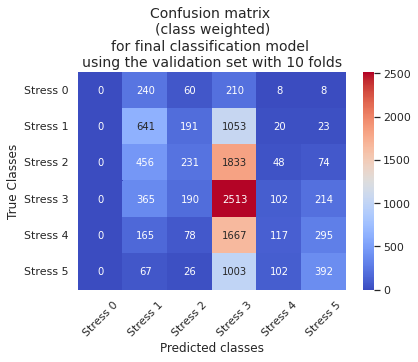

In [ ]:
######################################### Confusion Matrix -- Validation set #############################################################

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

# Define the model
final_model = mlp_best

# Make predictions using CV with training set
cv=10
yhat_cv = cross_val_predict(final_model, X_train, y_train, cv=cv)

# Plot Confusion Matrix
class_names = ['Stress 0','Stress 1','Stress 2','Stress 3','Stress 4','Stress 5']
# sns.heatmap(confusion_matrix(y_train, yhat_cv, sample_weight=weight_array_train), annot=True, fmt='g', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
sns.heatmap(confusion_matrix(y_train, yhat_cv), annot=True, fmt='g', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)

# Settings
plt.title((f'Confusion matrix \n(class weighted)\nfor final classification model \nusing the validation set with {cv} folds'), fontsize=14)
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.xticks(rotation=45);

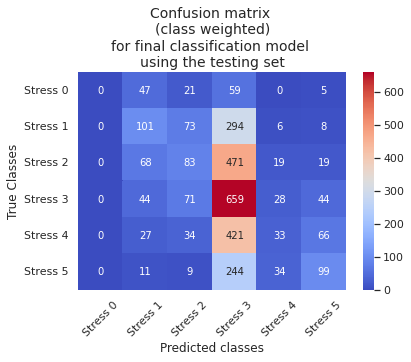

In [ ]:
######################################### Confusion Matrix -- Testing set #############################################################

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

# Define the model
final_model = mlp_best

# Make predictions using CV with testing set
yhat_test = final_model.predict(X_test)

# Plot Confusion Matrix
class_names = ['Stress 0','Stress 1','Stress 2','Stress 3','Stress 4','Stress 5']
# sns.heatmap(confusion_matrix(y_test, yhat_test, sample_weight=weight_array_test), annot=True, fmt='g', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)
sns.heatmap(confusion_matrix(y_test, yhat_test), annot=True, fmt='g', cmap='coolwarm', xticklabels=class_names, yticklabels=class_names)

# Settings
plt.title((f'Confusion matrix \n(class weighted)\nfor final classification model \nusing the testing set'), fontsize=14)
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.xticks(rotation=45);

### Classification Report -- Imbalanced

In [ ]:
from sklearn.model_selection import cross_val_predict
from imblearn.metrics import geometric_mean_score as gmean
from imblearn.metrics import classification_report_imbalanced, sensitivity_score, specificity_score

df = pd.DataFrame(columns=['Model','GMEAN (cv)', 'RECALL (cv)', 'GMEAN (testing)', 'RECALL (testing)', 'GMEAN (training)', 'RECALL (training)'])

def compute_pred(model, X_train, y_train, title=None):

  cv=10
  yhat_cv = cross_val_predict(model, X_train, y_train, cv=cv)

  class_names = ['Stress 0','Stress 1','Stress 2','Stress 3','Stress 4','Stress 5']

  report = classification_report_imbalanced(y_train, yhat_cv, sample_weight=weight_array_train, target_names=class_names, digits=3, output_dict=True)

  print('Classification Report -- Imbalanced -- using Validation Set\nwhere `avg/total` is calculated for each class and weighted by their support (not by class)\n' 
      + ("="*92) + '\n' + classification_report_imbalanced(y_train, yhat_cv, target_names=class_names, digits=3) + "="*92)

  ################################ Validation Set ########################################

  #---------Recall-----------
  cv_rec = report['avg_rec']*100

  #---------G-Mean-----------
  cv_gm = report['avg_geo']

  # append_scores = [title, cv_rec_baseline, cv_gm_baseline]


  #################################### Training Set ###########################################

  # Compute predictions
  yhat_train = model.predict(X_train)

  #---------Recall-----------
  train_rec = sensitivity_score(y_train, yhat_train, average='weighted', sample_weight=weight_array_train)*100

  #---------G-Mean-----------
  train_gm = gmean(y_train, yhat_train, average='weighted', sample_weight=weight_array_train)

    #################################### Testing Set ###########################################

  # Compute predictions
  yhat_test = model.predict(X_test)

  #---------Recall-----------
  test_rec = sensitivity_score(y_test, yhat_test, average='weighted', sample_weight=weight_array_test)*100

  #---------G-Mean-----------
  test_gm = gmean(y_test, yhat_test, average='weighted', sample_weight=weight_array_test)

  append_scores = [title,round(cv_gm,2),round(cv_rec,1),round(train_gm,2),round(train_rec,1),round(test_gm,2),round(test_rec,1)]
  df_length = len(df)
  df.loc[df_length] = append_scores

    # Display results
  print(f'\n\t>> Generalization error (mean of {cv} folds) <<')
  print(f'\nRecall (class weighted, cv) for {title} model: {round(cv_rec,1)}%')
  print(f'G-Mean (class weighted, cv) for {title} model: {round(cv_gm,2)}')

  print('\n\n\t>> Testing error <<')
  print(f'\nRecall (class weighted, test) for {title} model: {round(test_rec,1)}%')
  print(f'G-Mean (class weighted, test) for {title} model: {round(test_gm,2)}')

  print('\n\n\t>> Training error <<')
  print(f'\nRecall (class weighted, train) for {title} model: {round(train_rec,1)}%')
  print(f'G-Mean (class weighted, train) for {title} model: {round(train_gm,2)}')

In [ ]:
#baseline score
title = 'MPLClassifier'
compute_pred(mlp_best, X_train, y_train, title=title) 

Classification Report -- Imbalanced -- using Validation Set
where `avg/total` is calculated for each class and weighted by their support (not by class)
                   pre       rec       spe        f1       geo       iba       sup

   Stress 0      0.000     0.000     1.000     0.000     0.000     0.000       526
   Stress 1      0.334     0.301     0.889     0.317     0.518     0.252      1928
   Stress 2      0.261     0.123     0.906     0.168     0.334     0.103      2642
   Stress 3      0.308     0.711     0.399     0.429     0.532     0.292      3384
   Stress 4      0.303     0.072     0.962     0.117     0.264     0.063      2322
   Stress 5      0.391     0.253     0.942     0.307     0.488     0.222      1590

avg / total      0.299     0.313     0.784     0.264     0.409     0.181     12392

	>> Generalization error (mean of 10 folds) <<

Recall (class weighted, cv) for MPLClassifier model: 29.8%
G-Mean (class weighted, cv) for MPLClassifier model: 0.49


	>> Testing er